# NLP要解决的任务
- 1.处理文本数据，首先对文本数据进行分词操作（分词的方法可能会不同，中文常见的就是分词或者分字）
- 2.分完的词计算机无法识别，需要将字符映射成实际的特征（向量）
- 3.构建模型（一般都用预训练模型，例如BERT，GPT系列等）
- 4.完成自己的任务，在预训练模型的基础上进行微调（训练自己数据的过程）

# 简单完成一个任务
- Huggingface这个包基本上就是调用即可，开箱即用的过程

In [5]:
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline  # 用人家设计好的流程完成一些简单的任务
classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a Huggingface course my whole life.",
        "I hate this so much",
    ]

)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 17 files to the new cache system


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.16s/it]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 628kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 268M/268M [00:41<00:00, 6.46MB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 48.0/48.0 [00:00<00:00, 48.0kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 232k/232k [00:03<00:00, 61.6kB/s]


[{'label': 'POSITIVE', 'score': 0.9598047137260437},
 {'label': 'NEGATIVE', 'score': 0.9995144605636597}]

如果遇到‘tensorflwo_core.keras.activations' has no attribute 'swish'注释掉即可  
- D:\ProgramData\Anaconda3\lib\site-packages\transformers\activations_tf.py

# 基本流程概述分析
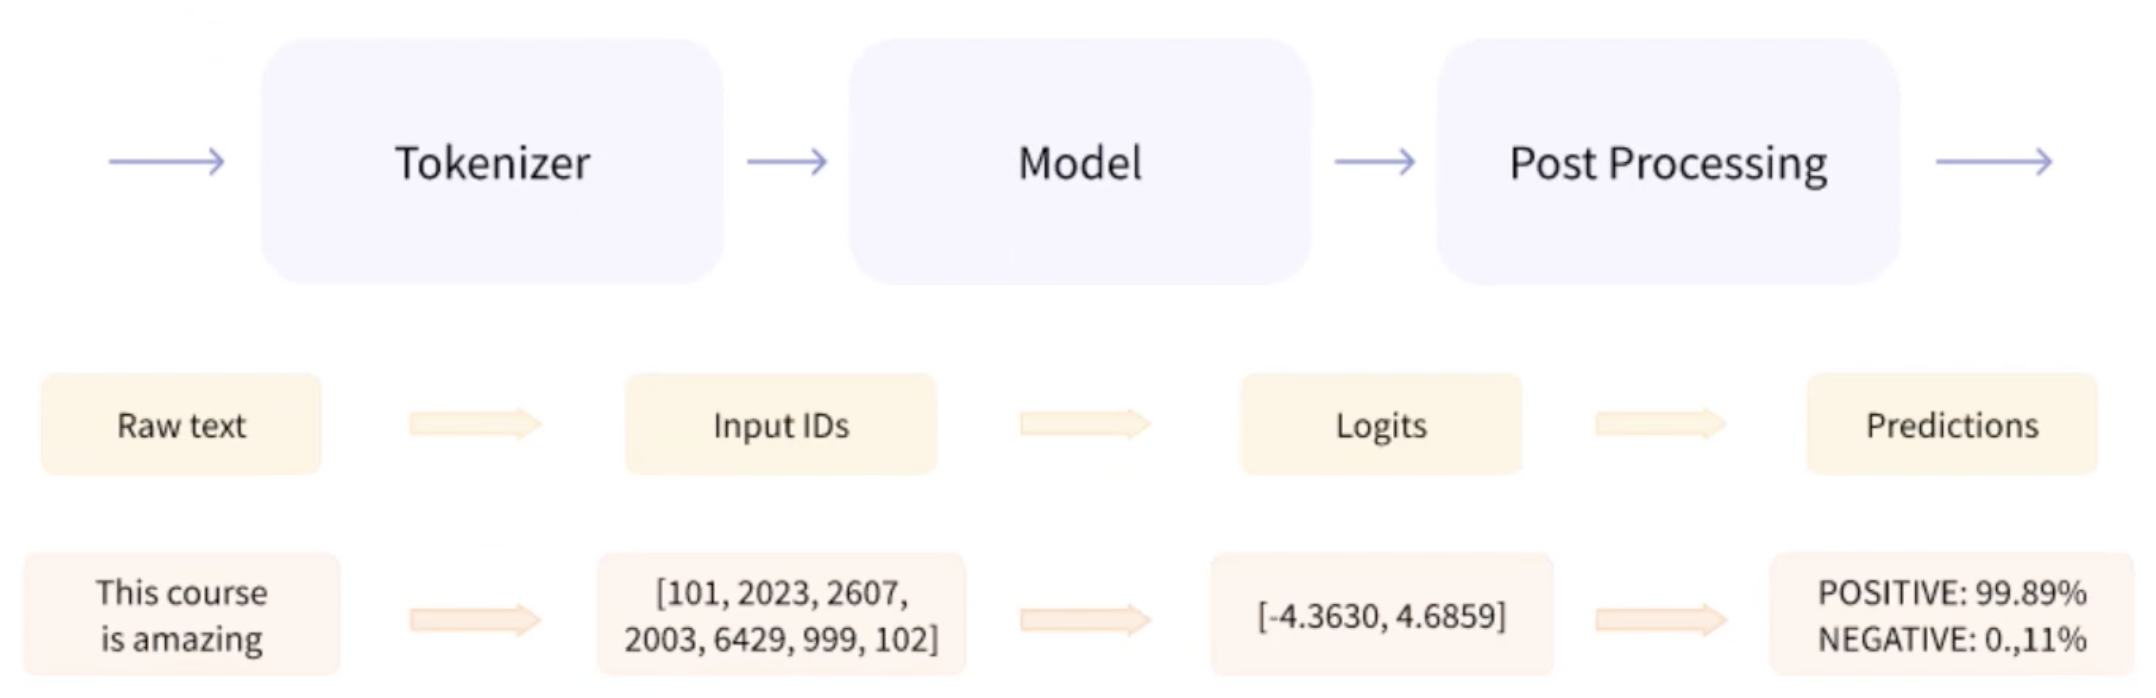
分词器（Tokenizer）、模型（Model）、后处理（Post Processing）
Raw text、Input IDs、Logits、Predicitons
- 输入是文本
- 对文本进行分词
- 将每个词转换为唯一的ID
- 将这些词的ID作为数据输入模型进行训练得到预测数值结果
- 通过后处理操作将预测数值结果转为现实结果

# Tokenizer（分词器）要做的事：
- 分词，分字以及特殊字符（起始，终止，间隔，分类等特殊字符可以自己设计的）
- 队每一个token映射得到一个ID（每个词都会对应一个唯一的ID）
- 还有一些辅助信息也可以得到，比如当前词属于哪个句子（还有一些MASK，表示是否是原来的词还是特殊字符等）

In [6]:
from transformers import AutoTokenizer  # 自动判断

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"  # 根据这个模型所对应的来加载
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [7]:
raw_inputs = [
    "I've been waiting for a this course my whole life.",
    "I hate this so much!",
]
# padding：默认为True，以最长的数据为准补齐，用0来表示补齐的内容
# truncation：截断
# return_tensors：此处选择是pytorch的tensor
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 1045, 5223, 2023, 2061, 2172,  999,  102,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


# attention_mask：
- 1表示和谁去算attention
- 0表示的没有用的，不会参与到attention的计算中

In [8]:
tokenizer.decode([101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102])

"[CLS] i've been waiting for a this course my whole life. [SEP]"

# 特殊字符
这些特殊字符是因为人家模型训练的时候就加入了这个东西，所以这里默认也加入了  
这些字符会自动的加入到固定的位置上
- [CLS]：分类字符，101
- [SEP]：终止字符，102（分隔，终止）

# 模型的加载方法
- 直接指定好名字即可，这里先不加输出层

In [9]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [11]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 15, 768])


- 2代表两个文本
- 15代表token
- 768代表每个token拥有的维度

# 模型的基本逻辑
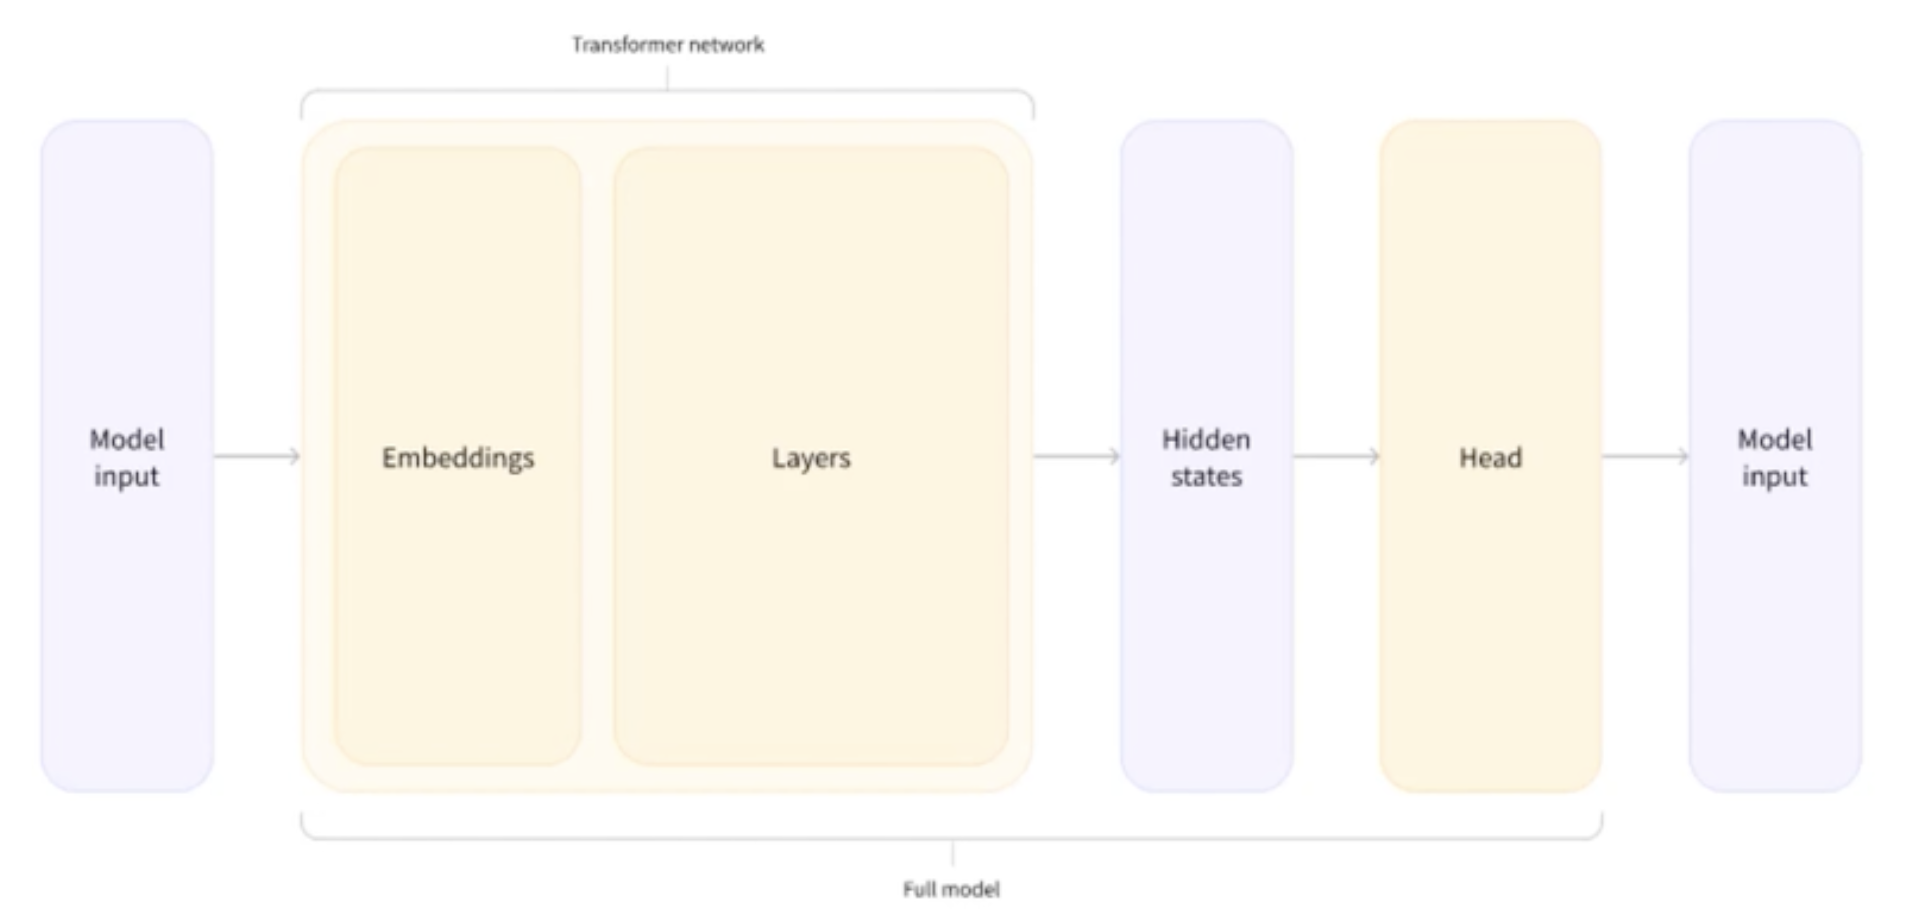

# 输出头
- 不同的输出头来实现不同的任务

In [12]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([2, 2])


In [13]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

# 最终获得类别

In [14]:
import torch

predicitons = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predicitons)

tensor([[1.5446e-02, 9.8455e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward>)


id2label可以自行设计，标签名字对应都可以自己指定

In [15]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

# padding的作用

In [17]:
sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)

print(model(torch.tensor(batched_ids)).logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward>)
tensor([[ 1.5694, -1.3895],
        [ 1.3373, -1.2163]], grad_fn=<AddmmBackward>)


自选id与默认id不同，导致在batched_ids中获得的结果与单个结果不同，所以在指定id的同时还需要指点attention_mask，在不指定attention_mask时padding还是会计算的attention

# attention_mask的作用

In [18]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward>)


# 不同的padding方法

In [19]:
sequences = [
    "I've been waiting for a this course my whole life.",
    "So have I!",
    "I played basketball yesterday."
]

In [21]:
# 按照最长的填充
model_inputs = tokenizer(sequences, padding='longest')
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2209, 3455, 7483, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [23]:
# BERT默认最大是512
# padding='max_length'：表示模型所能承受的最大长度
model_inputs = tokenizer(sequences, padding='max_length')
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
# 填充到多少
# 指定长度，如果长度超过指定长度则没有padding，如果长度小于指定长度则padding到指定长度
model_inputs = tokenizer(sequences, padding='max_length', max_length=8)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0], [101, 1045, 2209, 3455, 7483, 1012, 102, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0]]}

In [33]:
# 到多少就截短
# truncation=True：表示到指定最大长度时是否截短
model_inputs = tokenizer(sequences, padding='max_length', max_length=10, truncation=True)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0], [101, 1045, 2209, 3455, 7483, 1012, 102, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]}

In [26]:
# 最好返回tensor
# 通过return_tensors指定返回的模式
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")
model_inputs

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 2061, 2031, 1045,  999,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [ 101, 1045, 2209, 3455, 7483, 1012,  102,    0,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}